In [44]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [69]:
model_filepath = "drive/MyDrive/NLU Coursework/solution_C/models_C/best_solution_C.pt" #Path to the model to be demoed
dataset_path = "drive/MyDrive/NLU Coursework/data/training_data/training_data/NLI/dev.csv" #Path to the dataset used for evaluation
labels_path = "drive/MyDrive/NLU Coursework/submissions/Group_17_C.csv" #Path to output the predicted labels

# Evaluation Setup

In [46]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from keras.utils import to_categorical

In [47]:
import json
from random import randint
import os
import random
from nltk.corpus import wordnet, stopwords
from itertools import chain
import nltk

## Functions

In [48]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import typing
import keras

@dataclass(frozen=True)
class GeneralKeys:
    """
    Dataclass for general keys for the process
    """

    PREMISE_KEY: str = "Premise"
    HYPOTHESIS_KEY: str = "Hypothesis"
    LABEL_KEY: str = "Label"
    LOSS_KEY: str = "Loss"
    PREDICTED_KEY: str = "Predicted Label"
    TRUE_KEY: str = "True Label"


@dataclass
class MacroMetric:
    """
    Dataclass for metrics that can be turned into macro & weighted macro
    """

    NORMAL_KEY: str
    MACRO_KEY: str
    WEIGHTED_KEY: str

    def __init__(self, key: str):
        self.NORMAL_KEY: str = key
        self.MACRO_KEY: str = f"Macro {key}"
        self.WEIGHTED_KEY: str = f"Weighted Macro {key}"


@dataclass(frozen=True)
class MetricKeys:
    """
    Dataclass associated with keys for the evaluation metrics
    """

    ACCURACY_KEY: str = "Accuracy"
    PRECISION: MacroMetric = MacroMetric(key="Precision")
    F1: MacroMetric = MacroMetric(key="F1-Score")
    RECALL: MacroMetric = MacroMetric(key="Recall")
    MCC_KEY: str = "MCC"
    LOSS_KEY: str = "Loss"


def evaluate(true_labels: np.array, predicted_logits: np.array) -> pd.DataFrame:
    """
    Uses the true and predicted labels & sklearn to create extensive evaluation metrics. Formats into a dataframe that it returns

    true_labels:        (N) sized array storing the true (0, 1) labels of the data
    predicted_logits:   (N, 2) sized array storing the predicted logits from the model, therefore the predicted probabilities for either class
    """
    loss = log_loss(true_labels, predicted_logits)  # Uses logits for loss

    # Otherwise utilises argmax of the prediction logits, to get the predicted labels
    predicted_labels = np.argmax(predicted_logits, axis=1)

    accuracy = accuracy_score(true_labels, predicted_labels)

    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, predicted_labels
    )

    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    macro_precision = precision_score(true_labels, predicted_labels, average="macro")
    macro_recall = recall_score(true_labels, predicted_labels, average="macro")
    macro_f1 = f1_score(true_labels, predicted_labels, average="macro")

    mcc = matthews_corrcoef(true_labels, predicted_labels)

    # Format into dataframe for easier viewing
    df = pd.DataFrame(
        [
            [
                accuracy,
                precision,
                macro_precision,
                weighted_precision,
                recall,
                macro_recall,
                weighted_recall,
                f1,
                macro_f1,
                weighted_f1,
                mcc,
                loss,
            ]
        ],
        columns=[
            MetricKeys.ACCURACY_KEY,
            MetricKeys.PRECISION.NORMAL_KEY,
            MetricKeys.PRECISION.MACRO_KEY,
            MetricKeys.PRECISION.WEIGHTED_KEY,
            MetricKeys.RECALL.NORMAL_KEY,
            MetricKeys.RECALL.MACRO_KEY,
            MetricKeys.RECALL.WEIGHTED_KEY,
            MetricKeys.F1.NORMAL_KEY,
            MetricKeys.F1.MACRO_KEY,
            MetricKeys.F1.WEIGHTED_KEY,
            MetricKeys.MCC_KEY,
            MetricKeys.LOSS_KEY,
        ],
    )
    return df


@dataclass
class ClassLabels:
    """
    Dataclass for the string class labels. Used in the confusion matrix generation
    """

    ZERO_KEY: str = "Not Entailing"
    ONE_KEY: str = "Entailing"


def draw_confusion_matrix(
    true_labels: np.array,
    predicted_logits: np.array,
    classes: typing.List[str] = [ClassLabels.ZERO_KEY, ClassLabels.ONE_KEY],
) -> np.array:
    """
    Will make a confusion matrix using the predicted and true values & will display this. Returns the confusion matrix as an array
    """
    predicted_labels = np.argmax(predicted_logits, axis=1)

    conf_mat = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp.plot()
    plt.show()
    return conf_mat


def most_confused_samples(
    true_logits: np.array,
    predicted_logits: np.array,
    premises: typing.List[str],
    hypotheses: typing.List[str],
    num: int = 5,
    loss_function: callable = keras.losses.categorical_crossentropy,
) -> pd.DataFrame:
    """
    Will print the num samples with the highest loss

    true_logits:        (N, 2) sized array storing the one hot encoded labels of the data
    predicted_logits:   (N, 2) sized array storing the predicted logits from the model, therefore the predicted probabilities for either class
    premises:           (N) sized array storing the string premises
    hypotheses:         (N) sized array storing the string hypotheses

    num:                Integer number of samples to report about. The top M (or num) samples will be displayed
    loss_function:      Executable function used for the loss calculation. By default this is just categorical cross entropy
    """
    # Gets the samples that have the highest loss
    loss_per_sample = [
        loss.numpy() for loss in loss_function(true_logits, predicted_logits)
    ]
    largest_indices = np.argsort(loss_per_sample)[-num:][::-1]

    predicted_labels = np.argmax(predicted_logits, axis=1)
    true_labels = np.argmax(true_logits, axis=1)

    # Makes the dataframe with the confused samples
    confused_samples = [
        [
            premises[i],
            hypotheses[i],
            loss_per_sample[i],
            predicted_labels[i],
            true_labels[i],
        ]
        for i in largest_indices
    ]
    df = pd.DataFrame(
        confused_samples,
        columns=[
            GeneralKeys.PREMISE_KEY,
            GeneralKeys.HYPOTHESIS_KEY,
            GeneralKeys.LOSS_KEY,
            GeneralKeys.PREDICTED_KEY,
            GeneralKeys.TRUE_KEY,
        ],
    )
    return df

In [49]:
import typing
from dataclasses import dataclass
import pandas as pd
import os
import random
from nltk.corpus import wordnet, stopwords
from itertools import chain
import nltk
import numpy as np

@dataclass(frozen=True)
class DatasetKeys:
    """
    Dataclass associated with keys for the data csvs
    """

    PREMISE_KEY: str = GeneralKeys.PREMISE_KEY.lower()
    HYPOTHESIS_KEY: str = GeneralKeys.HYPOTHESIS_KEY.lower()
    LABEL_KEY: str = GeneralKeys.LABEL_KEY.lower()

def load_data_csv(
    filepath: str,
) -> typing.Tuple[typing.List[str], typing.List[str], typing.List[int]]:
    """
    Will load in data from the csv filepath specified. Expects the string filepath to a csv file. Returns tuple of the premises, hypotheses and labels
    """
    dataset = pd.read_csv(filepath)
    premises = dataset[DatasetKeys.PREMISE_KEY].astype(str).tolist()
    hypotheses = dataset[DatasetKeys.HYPOTHESIS_KEY].astype(str).tolist()
    labels = dataset[DatasetKeys.LABEL_KEY].astype(str).tolist()
    return (premises, hypotheses, labels)

In [50]:
def tokenize_data(tokenizer: RobertaTokenizer, premises: typing.List[str], hypotheses: typing.List[str], maxlen: int) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses together. Will padd/truncate the sequences of tokens correctly. Formats the sequences together of the format below

      sample = [CLS] Premise [SEP] Hypothesis [SEP]
  """
  return tokenizer(premises, hypotheses, max_length=maxlen, padding="max_length", truncation=True, return_tensors="pt", add_special_tokens=True)

## Variables

In [51]:
INPUTS_IDS_KEY: str = "input_ids"
ATTENTION_MASK_KEY: str = "attention_mask"
TOKEN_TYPE_KEY: str = "token_type_ids"

In [52]:
NUM_LABELS = 2

# Data Preprocessing

## Load Data

In [53]:
premises, hypotheses, true = load_data_csv(filepath=dataset_path)

In [54]:
premises_og = premises
hypotheses_og = hypotheses

In [55]:
true = [int(x) for x in true]
labels = torch.tensor(true)

### Example

In [56]:
index = randint(0, len(premises))
print(f"Premise: {premises[index]}")
print(f"Hypothesis: {hypotheses[index]}")
print(f"Label: {labels[index]}")

Premise: Britain won Canada and everything east of the Mississippi, including Spanish Florida.
Hypothesis: The United States lost Canada and Spanish Florida.
Label: 1


## Tokenize Data

In [57]:
BERT_ID: str = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(BERT_ID, do_lower_case=True)

In [58]:
demo_data = tokenize_data(tokenizer=tokenizer, premises=list(premises), hypotheses=list(hypotheses), maxlen=512)

In [59]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 50265


### Example

In [60]:
print(f"Sentence: {tokenizer.convert_ids_to_tokens(demo_data[INPUTS_IDS_KEY][0])}")
print(f"Tokens: {demo_data[INPUTS_IDS_KEY]}")

Sentence: ['<s>', 'Mon', 'ĠDie', 'u', '!', 'Ġ', '</s>', '</s>', 'This', 'Ġperson', 'Ġis', 'Ġspeaking', 'ĠEnglish', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

## Format Dataset & Dataloader

In [61]:
dataset = TensorDataset(demo_data[INPUTS_IDS_KEY], demo_data[ATTENTION_MASK_KEY], labels) #note here that the dev dataset is used for testing (evaluation) later
dataloader = DataLoader(dataset, batch_size = 16)


# Load Model

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [63]:
model = RobertaForSequenceClassification.from_pretrained(BERT_ID, num_labels=NUM_LABELS)

model = model.to(device)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [64]:
model.load_state_dict(torch.load(model_filepath))

<All keys matched successfully>

# Make Predictions


In [65]:
#Get the predictions for all of the test cases
predicted_logits = []

for batch in dataloader:
  input_ids, attention_mask, labels = [part.to(device) for part in batch]

  with torch.no_grad():
    outputs = model(input_ids = input_ids,
                    attention_mask = attention_mask,
                    labels=labels)

  predicted_logits.extend(outputs.logits.detach().cpu())
predicted_logits = np.array(predicted_logits)

In [66]:
predicted_labels = np.argmax(predicted_logits, axis=1)

In [70]:
output_labels = pd.DataFrame(
    predicted_labels,
    columns=["prediction"]
)
output_labels.to_csv(labels_path, index=False)
output_labels

,prediction
0,1
1,0
2,0
3,1
4,1
...,...
6732,0
6733,0
6734,1
6735,0


# Evaluation

In [71]:
#Evaluation Metrics
test_metrics = evaluate(true_labels=true, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv("solution_B_metrics.csv", index=False)
test_metrics

,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.85216,0.889272,0.854047,0.855192,0.815124,0.853404,0.85216,0.850585,0.852143,0.852093,0.707451,2.101688


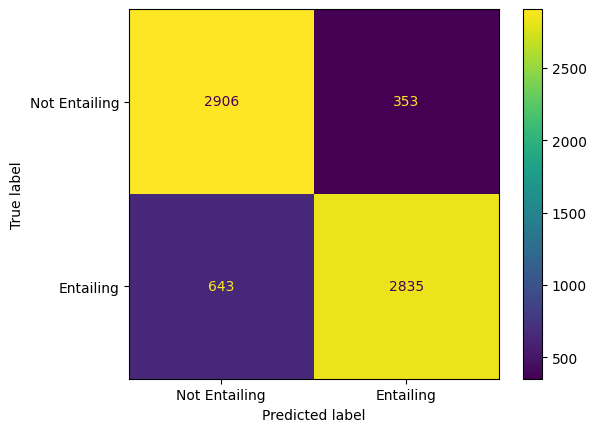

In [72]:
#Confusion matrix
conf_mat = draw_confusion_matrix(true_labels=true, predicted_logits=np.array(predicted_logits))

In [ ]:
#Show the most confused samples
df = most_confused_samples(true_logits=to_categorical(true), predicted_logits=np.array(predicted_logits), premises=premises_og, hypotheses=hypotheses_og, num=10)
df